In [1]:
%%capture
%config InlineBackend.figure_format = 'retina'
from sklearn import datasets, impute, neighbors, preprocessing, svm, compose, tree, linear_model, neural_network
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import warnings
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import json

warnings.filterwarnings('ignore')
# pip install gspread and df2gspread
import sys
!{sys.executable} -m pip install gspread
!{sys.executable} -m pip install numpy df2gspread
import gspread
from df2gspread import gspread2df as g2d
from oauth2client.service_account import ServiceAccountCredentials

In [2]:
# Where we want the credentials to be sent in order to be authorized
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
keyfile = 'gserviceaccount-client-secret.json'

try:
    credentials = ServiceAccountCredentials.from_json_keyfile_name(keyfile, scope)
    gc = gspread.authorize(credentials)
    
    spreadsheet_key = '1QUMP6tlBqR3CqYlh7uC18e_XA4FgMT9SqMSc5agoGUA'
    
    df = g2d.download(
        spreadsheet_key,
        wks_name='Results',
        credentials=credentials,
        col_names=True,
    )
    
    df.to_csv('data/results.csv', index=False)
    print('Read data frame from Google Sheets')
except:
    df = pd.read_csv('data/results.csv')
    print('Read data from cache')



Read data frame from Google Sheets


In [3]:
# Two of the columns contain Python dicts that have been serialized.
# This serves to deserialize them into dicts again, in a totally utterly unsafe way. 
for i, (p, cv) in enumerate(zip(df['params'], df['cv_results'])):
    from numpy import array, int32
    from numpy.ma import masked_array
    # This is horrible. Don't do this.
    # However, since I happen to be the one who generates the output it's slightly less horrible,
    # though definitely still a huge no-go.
    df['params'][i] = eval(p)
    df['cv_results'][i] = eval(cv)

# Transform the ones we need as numbers to float.
for column in ['f_score', 'training_accuracy', 'validation_accuracy', 'test_accuracy']:
    df[column] = df[column].apply(float)
    
df

,dataset,train_size,trial,classifier,f_score,training_accuracy,validation_accuracy,test_accuracy,params,cv_results
0,california_housing,0.2,0,RF,0.874319,0.999879,0.873789,0.874334,"{'max_depth': 16, 'n_estimators': 50}","{'mean_fit_time': [6.500666, 11.63643231, 18.0..."
1,california_housing,0.2,0,KNN,0.821280,0.840904,0.814928,0.821342,{'n_neighbors': 16},"{'mean_fit_time': [0.01466913, 0.05092106, 0.1..."
2,california_housing,0.2,0,SVM,0.842090,0.848293,0.848601,0.842115,{'C': 100},"{'mean_fit_time': [0.05822906, 0.0730166, 0.08..."
3,california_housing,0.2,0,DT,0.814447,0.863977,0.818555,0.814499,"{'criterion': 'entropy', 'min_samples_split': ...","{'mean_fit_time': [0.25879779, 0.27705407, 0.1..."
4,california_housing,0.2,0,LR,0.841316,0.845325,0.843998,0.841328,{'C': 100},"{'mean_fit_time': [0.2993731, 0.38455644, 0.15..."
...,...,...,...,...,...,...,...,...,...,...
427,bank (pca),0.8,2,KNN,0.622402,0.894299,0.893303,0.890302,{'n_neighbors': 64},"{'mean_fit_time': [3.41654058, 4.69879498, 2.7..."
428,bank (pca),0.8,2,SVM,0.565262,0.888880,0.888769,0.883003,{'C': 1e-08},"{'mean_fit_time': [0.49178166, 0.58363428, 0.7..."
429,bank (pca),0.8,2,DT,0.623450,0.892149,0.887912,0.884330,"{'criterion': 'entropy', 'min_samples_split': ...","{'mean_fit_time': [5.07530718, 4.73675432, 3.5..."
430,bank (pca),0.8,2,LR,0.606043,0.892695,0.892585,0.886210,{'C': 0.01},"{'mean_fit_time': [2.40566754, 2.2522296, 2.08..."


In [4]:
def latex_df(table, datasets = None, columns = None):
    table = table.copy()
    datasets = datasets or table.index.get_level_values('dataset').unique()
    columns = columns or table.columns
    
    for dataset in table.index.get_level_values('dataset').unique():
        yield '&'.join([dataset.replace('_', '\\_')] + 9 * ['']) + '\\\\'
        yield '\\midrule'
        subtable = table.loc[dataset].copy()
        for column in columns:
            largest = subtable[column].max()
            subtable[column] = subtable[column].apply(
                lambda x: f'\\textbf{{{x:.2f}}}' if x == largest else f'{x:.2f}'
            )
            
            
        for idx, row in subtable.iterrows():
            yield '&'.join([idx] + list(row)) + '\\\\'
            
    yield ''
            
def latex_table(table):
    delimiter = '\n'
    return f"""\\begin{{table*}}[]
\\centering
\\begin{{tabular}}{{lllllllllllll}}
& \\multicolumn{{3}}{{c}}{{F-Score}} & \\multicolumn{{3}}{{c}}{{Training}} & \\multicolumn{{3}}{{c}}{{Validation}} & \\multicolumn{{3}}{{c}}{{Testing}} \\\\
\\cmidrule(lr){{2-4}} \\cmidrule(lr){{5-7}} \\cmidrule(lr){{8-10}} \\cmidrule(lr){{11-13}}
& 0.2   & 0.5   & 0.8 & 0.2   & 0.5   & 0.8   & 0.2   & 0.5   & 0.8 & 0.2   & 0.5   & 0.8  \\\\
{delimiter.join(row for row in latex_df(table))}
\\bottomrule
\\end{{tabular}}
\\caption{{Accuracies attained by classifiers on each data set and partitioning ratio}}
\\label{{results-table}}
\\end{{table*}}"""

In [5]:
import subprocess
def clipboard(data):
    subprocess.run("pbcopy", universal_newlines=True, input=data)

In [6]:
df

,dataset,train_size,trial,classifier,f_score,training_accuracy,validation_accuracy,test_accuracy,params,cv_results
0,california_housing,0.2,0,RF,0.874319,0.999879,0.873789,0.874334,"{'max_depth': 16, 'n_estimators': 50}","{'mean_fit_time': [6.500666, 11.63643231, 18.0..."
1,california_housing,0.2,0,KNN,0.821280,0.840904,0.814928,0.821342,{'n_neighbors': 16},"{'mean_fit_time': [0.01466913, 0.05092106, 0.1..."
2,california_housing,0.2,0,SVM,0.842090,0.848293,0.848601,0.842115,{'C': 100},"{'mean_fit_time': [0.05822906, 0.0730166, 0.08..."
3,california_housing,0.2,0,DT,0.814447,0.863977,0.818555,0.814499,"{'criterion': 'entropy', 'min_samples_split': ...","{'mean_fit_time': [0.25879779, 0.27705407, 0.1..."
4,california_housing,0.2,0,LR,0.841316,0.845325,0.843998,0.841328,{'C': 100},"{'mean_fit_time': [0.2993731, 0.38455644, 0.15..."
...,...,...,...,...,...,...,...,...,...,...
427,bank (pca),0.8,2,KNN,0.622402,0.894299,0.893303,0.890302,{'n_neighbors': 64},"{'mean_fit_time': [3.41654058, 4.69879498, 2.7..."
428,bank (pca),0.8,2,SVM,0.565262,0.888880,0.888769,0.883003,{'C': 1e-08},"{'mean_fit_time': [0.49178166, 0.58363428, 0.7..."
429,bank (pca),0.8,2,DT,0.623450,0.892149,0.887912,0.884330,"{'criterion': 'entropy', 'min_samples_split': ...","{'mean_fit_time': [5.07530718, 4.73675432, 3.5..."
430,bank (pca),0.8,2,LR,0.606043,0.892695,0.892585,0.886210,{'C': 0.01},"{'mean_fit_time': [2.40566754, 2.2522296, 2.08..."


In [7]:
full_results = pd.pivot_table(df, index=['dataset', 'classifier'], columns=['train_size'], values=['f_score', 'test_accuracy', 'training_accuracy', 'validation_accuracy'])
full_results

f_score                     test_accuracy  \
train_size                          0.2       0.5       0.8           0.2   
dataset            classifier                                               
abalone            ANN         0.791162  0.805948  0.804452      0.791343   
                   DT          0.768324  0.772595  0.777456      0.768402   
                   KNN         0.766896  0.788769  0.792295      0.767903   
                   LR          0.783312  0.792807  0.789341      0.783463   
                   RF          0.781138  0.792362  0.803841      0.781568   
                   SVM         0.775960  0.792611  0.794922      0.776182   
adult              ANN         0.778071  0.785187  0.775533      0.849295   
                   DT          0.749598  0.761085  0.762639      0.832523   
                   KNN         0.748930  0.757949  0.763622      0.836166   
                   LR          0.762792  0.765122  0.763372      0.841796   
                   RF          0.764725  0.770642  0.780489      0.846863   
                   SVM         0.763336  0.763295  0.762756      0.842794   
bank               ANN         0.729749  0.741746  0.750403      0.904015   
                   DT          0.721584  0.714905  0.708999      0.897610   
                   KNN         0.622700  0.642462  0.653370      0.893251   
                   LR          0.696939  0.695506  0.700539      0.900956   
                   RF          0.687354  0.694801  0.701685      0.901831   
                   SVM         0.600524  0.641171  0.595289      0.891196   
bank (pca)         ANN         0.681053  0.690065  0.700396      0.893592   
                   DT          0.591605  0.631866  0.592657      0.885454   
                   KNN         0.598899  0.623925  0.623803      0.890542   
                   LR          0.619177  0.621865  0.617455      0.891565   
                   RF          0.637760  0.660480  0.666038      0.891389   
                   SVM         0.563129  0.571624  0.533484      0.887122   
california_housing ANN         0.864997  0.877358  0.879714      0.865007   
                   DT          0.815732  0.834150  0.831979      0.815811   
                   KNN         0.816531  0.829518  0.836496      0.816618   
                   LR          0.824101  0.840854  0.835140      0.824108   
                   RF          0.874968  0.889660  0.889416      0.874980   
                   SVM         0.826776  0.843180  0.840889      0.826793   
online             ANN         0.782591  0.792651  0.799450      0.893045   
                   DT          0.780846  0.791728  0.800888      0.890612   
                   KNN         0.696676  0.695827  0.715865      0.881150   
                   LR          0.722987  0.719252  0.737832      0.884090   
                   RF          0.779038  0.774234  0.794334      0.899973   
                   SVM         0.735931  0.731480  0.739811      0.887132   
online (pca)       ANN         0.780643  0.788085  0.793061      0.894161   
                   DT          0.738456  0.735291  0.758885      0.886456   
                   KNN         0.720429  0.731831  0.750586      0.885915   
                   LR          0.720999  0.718550  0.720077      0.885273   
                   RF          0.743338  0.761069  0.772420      0.889599   
                   SVM         0.724115  0.728452  0.734665      0.885949   
optdigits          ANN         0.966814  0.978076  0.985149      0.966785   
                   DT          0.803405  0.828342  0.836517      0.800934   
                   KNN         0.959931  0.972854  0.980908      0.959890   
                   LR          0.957696  0.965227  0.970067      0.957666   
                   RF          0.967364  0.976370  0.981188      0.967304   
                   SVM         0.946915  0.956351  0.958793      0.947064   

                                                  training_accuracy            \
train_size             

In [8]:
values = 'f_score'
f_scores = pd.pivot_table(df, index='dataset', columns='classifier', values=values)
clipboard(f_scores.to_latex())
f_scores

classifier,ANN,DT,KNN,LR,RF,SVM
dataset,,,,,,
abalone,0.800521,0.772792,0.782653,0.788487,0.792447,0.787831
adult,0.779597,0.757774,0.756834,0.763762,0.771952,0.763129
bank,0.740633,0.715163,0.639511,0.697662,0.694613,0.612328
bank (pca),0.690504,0.605376,0.615542,0.619499,0.654760,0.556079
california_housing,0.874023,0.827287,0.827515,0.833365,0.884681,0.836948
online,0.791564,0.791154,0.702789,0.726690,0.782535,0.735741
online (pca),0.787263,0.744211,0.734282,0.719876,0.758942,0.729077
optdigits,0.976680,0.822755,0.971231,0.964330,0.974974,0.954019


In [9]:
avg_f_scores = f_scores.agg(np.average)
avg_f_scores

classifier
ANN    0.805098
DT     0.754564
KNN    0.753795
LR     0.764209
RF     0.789363
SVM    0.746894
dtype: float64

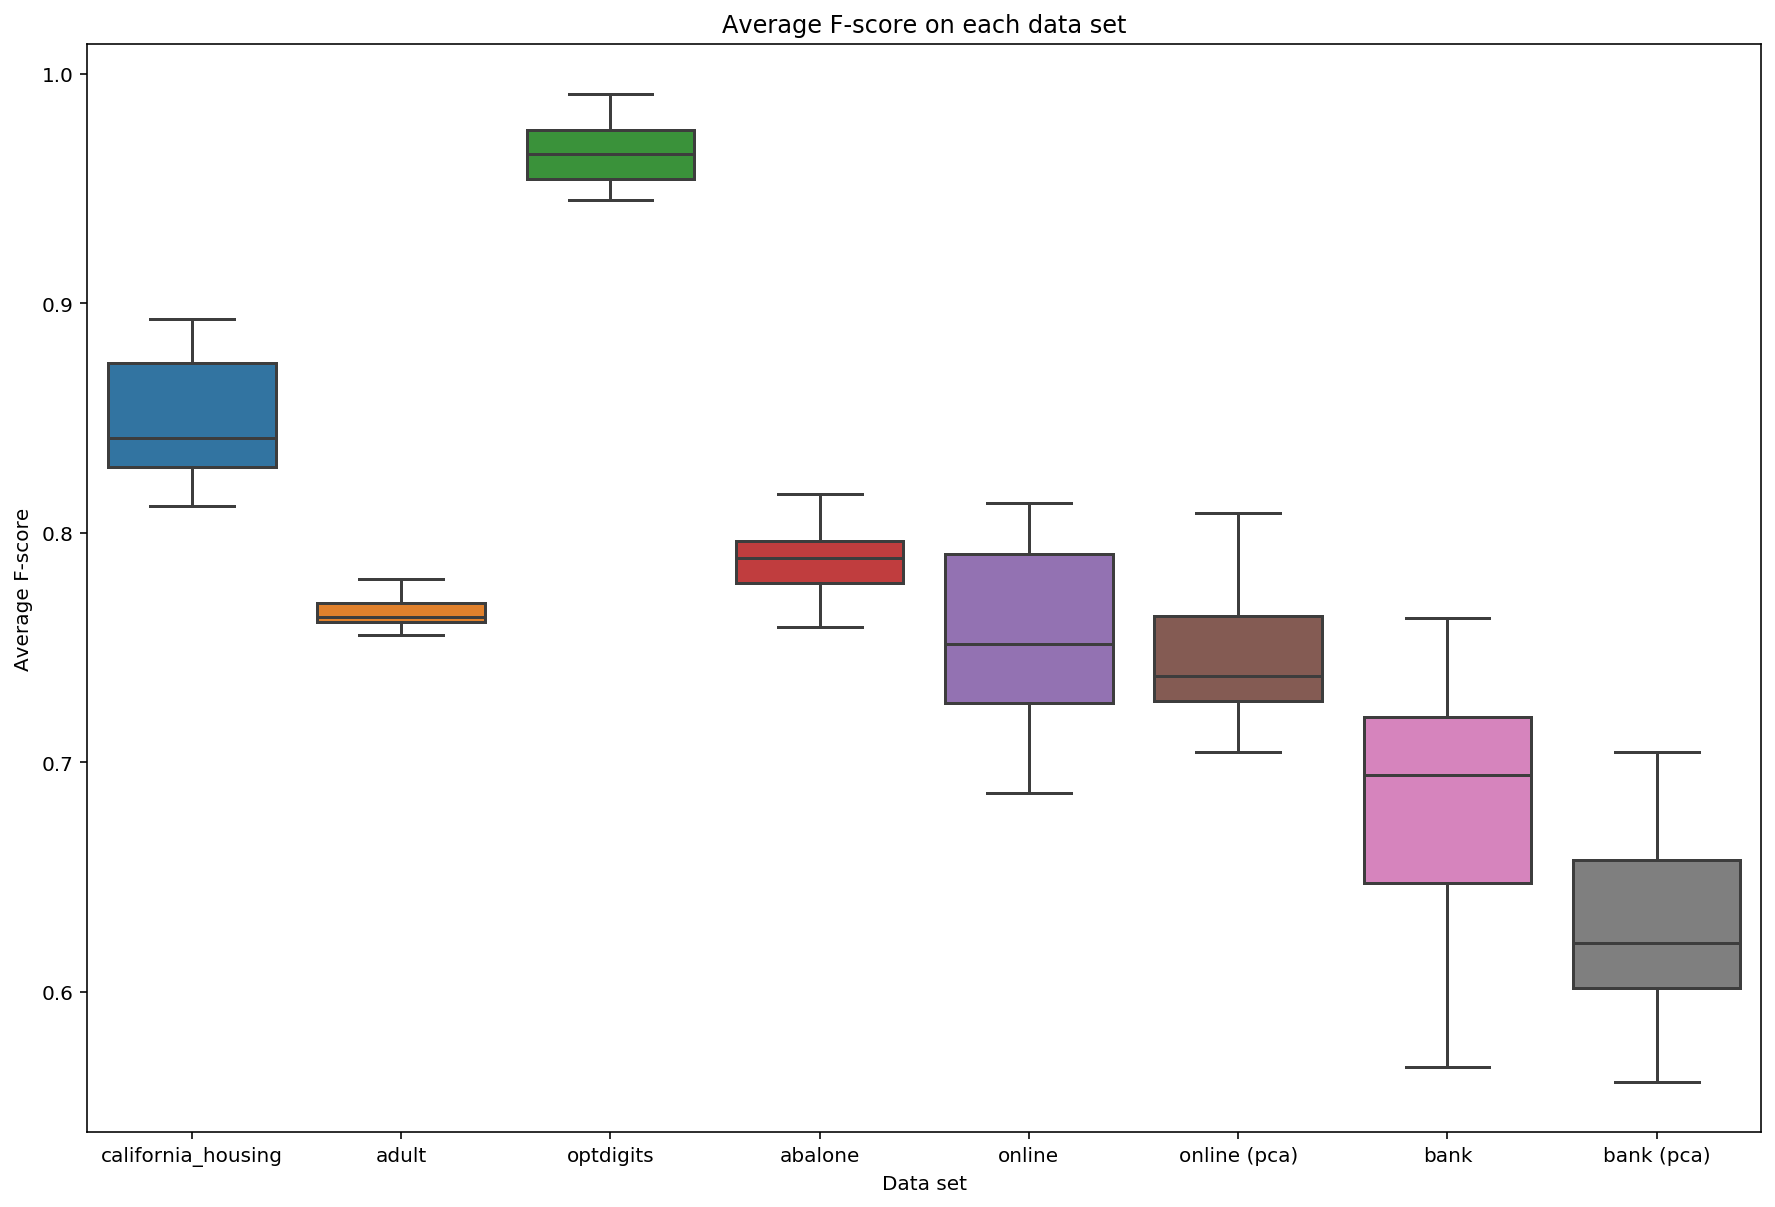

In [10]:
plt.figure(figsize=(15, 10))
ax = sns.boxplot(x = 'dataset', y='f_score', data=df, showfliers=False)
ax.set(xlabel='Data set', ylabel='Average F-score')
ax.set_title('Average F-score on each data set');
plt.savefig(f'plots/f_score_per_data_set', dpi=1000)

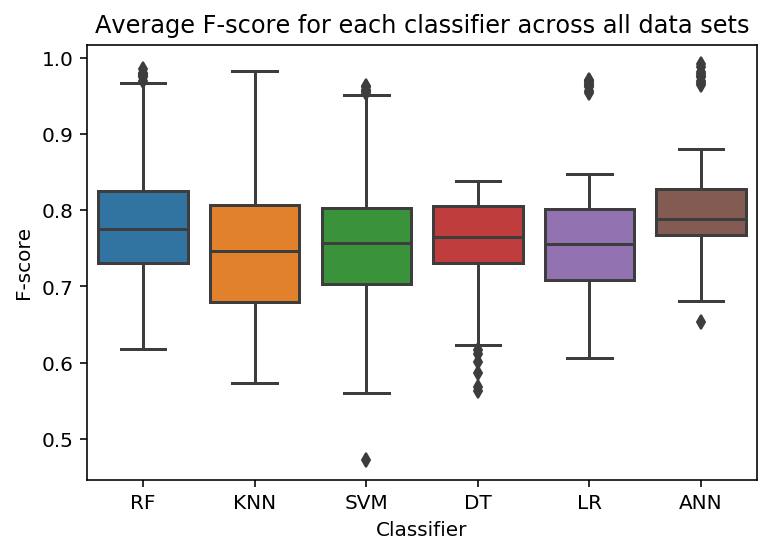

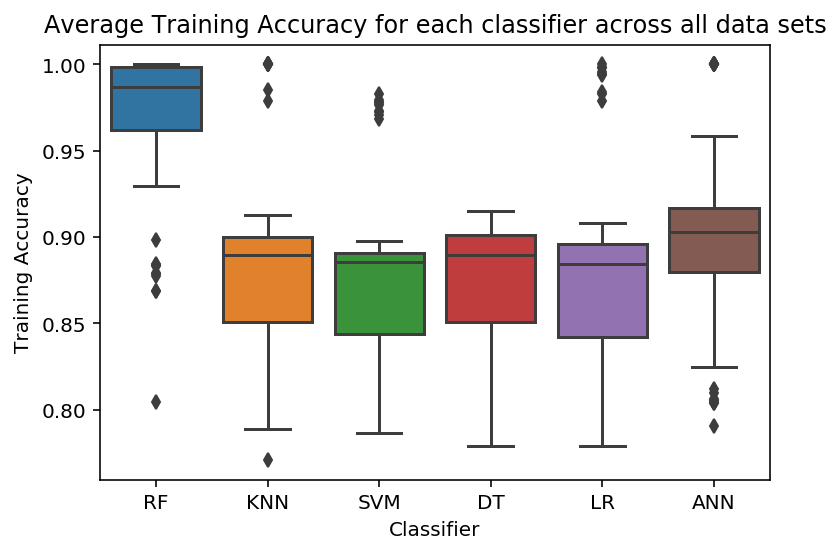

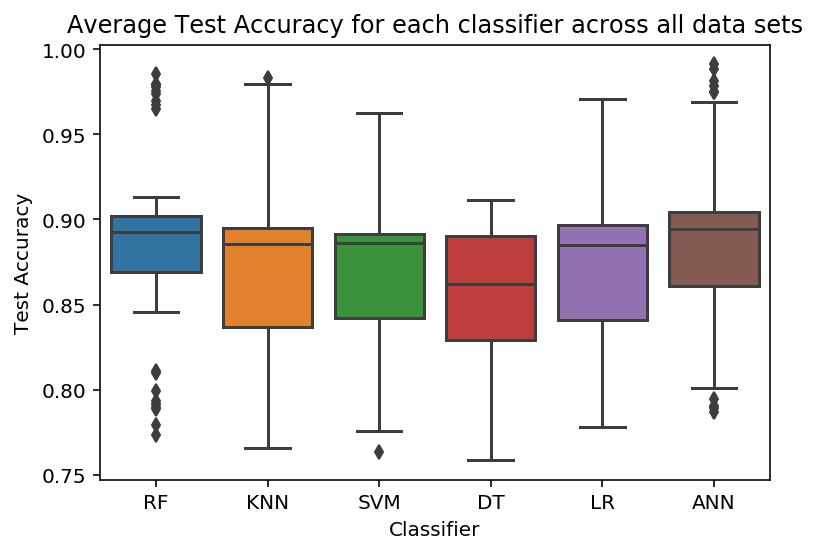

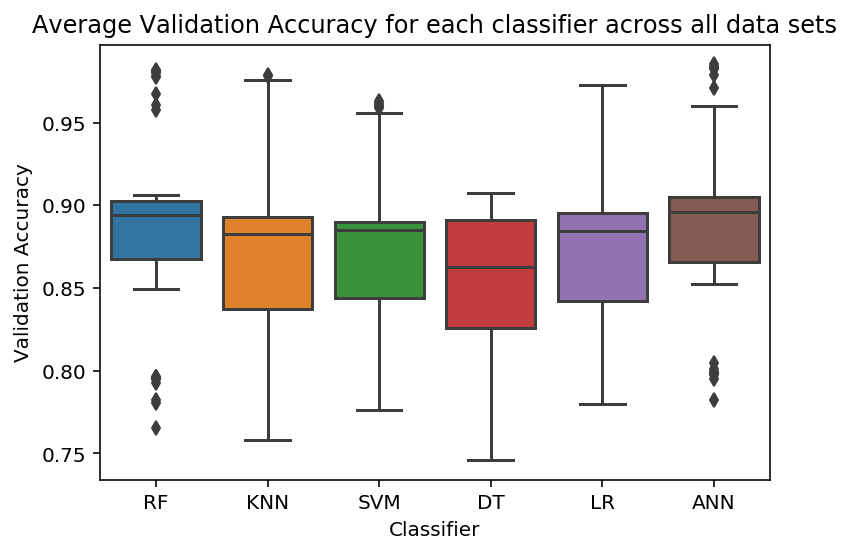

In [11]:
for y, ylabel in [('f_score', 'F-score'), ('training_accuracy', 'Training Accuracy'), ('test_accuracy', 'Test Accuracy'), ('validation_accuracy', 'Validation Accuracy')]:
    ax = sns.boxplot(x = 'classifier', y=y, data=df, showfliers=True)
    ax.set(xlabel='Classifier', ylabel=ylabel)
    ax.set_title(f'Average {ylabel} for each classifier across all data sets');
    plt.savefig(f'plots/avg_{y}_per_classifier', dpi=1000)
    plt.show()

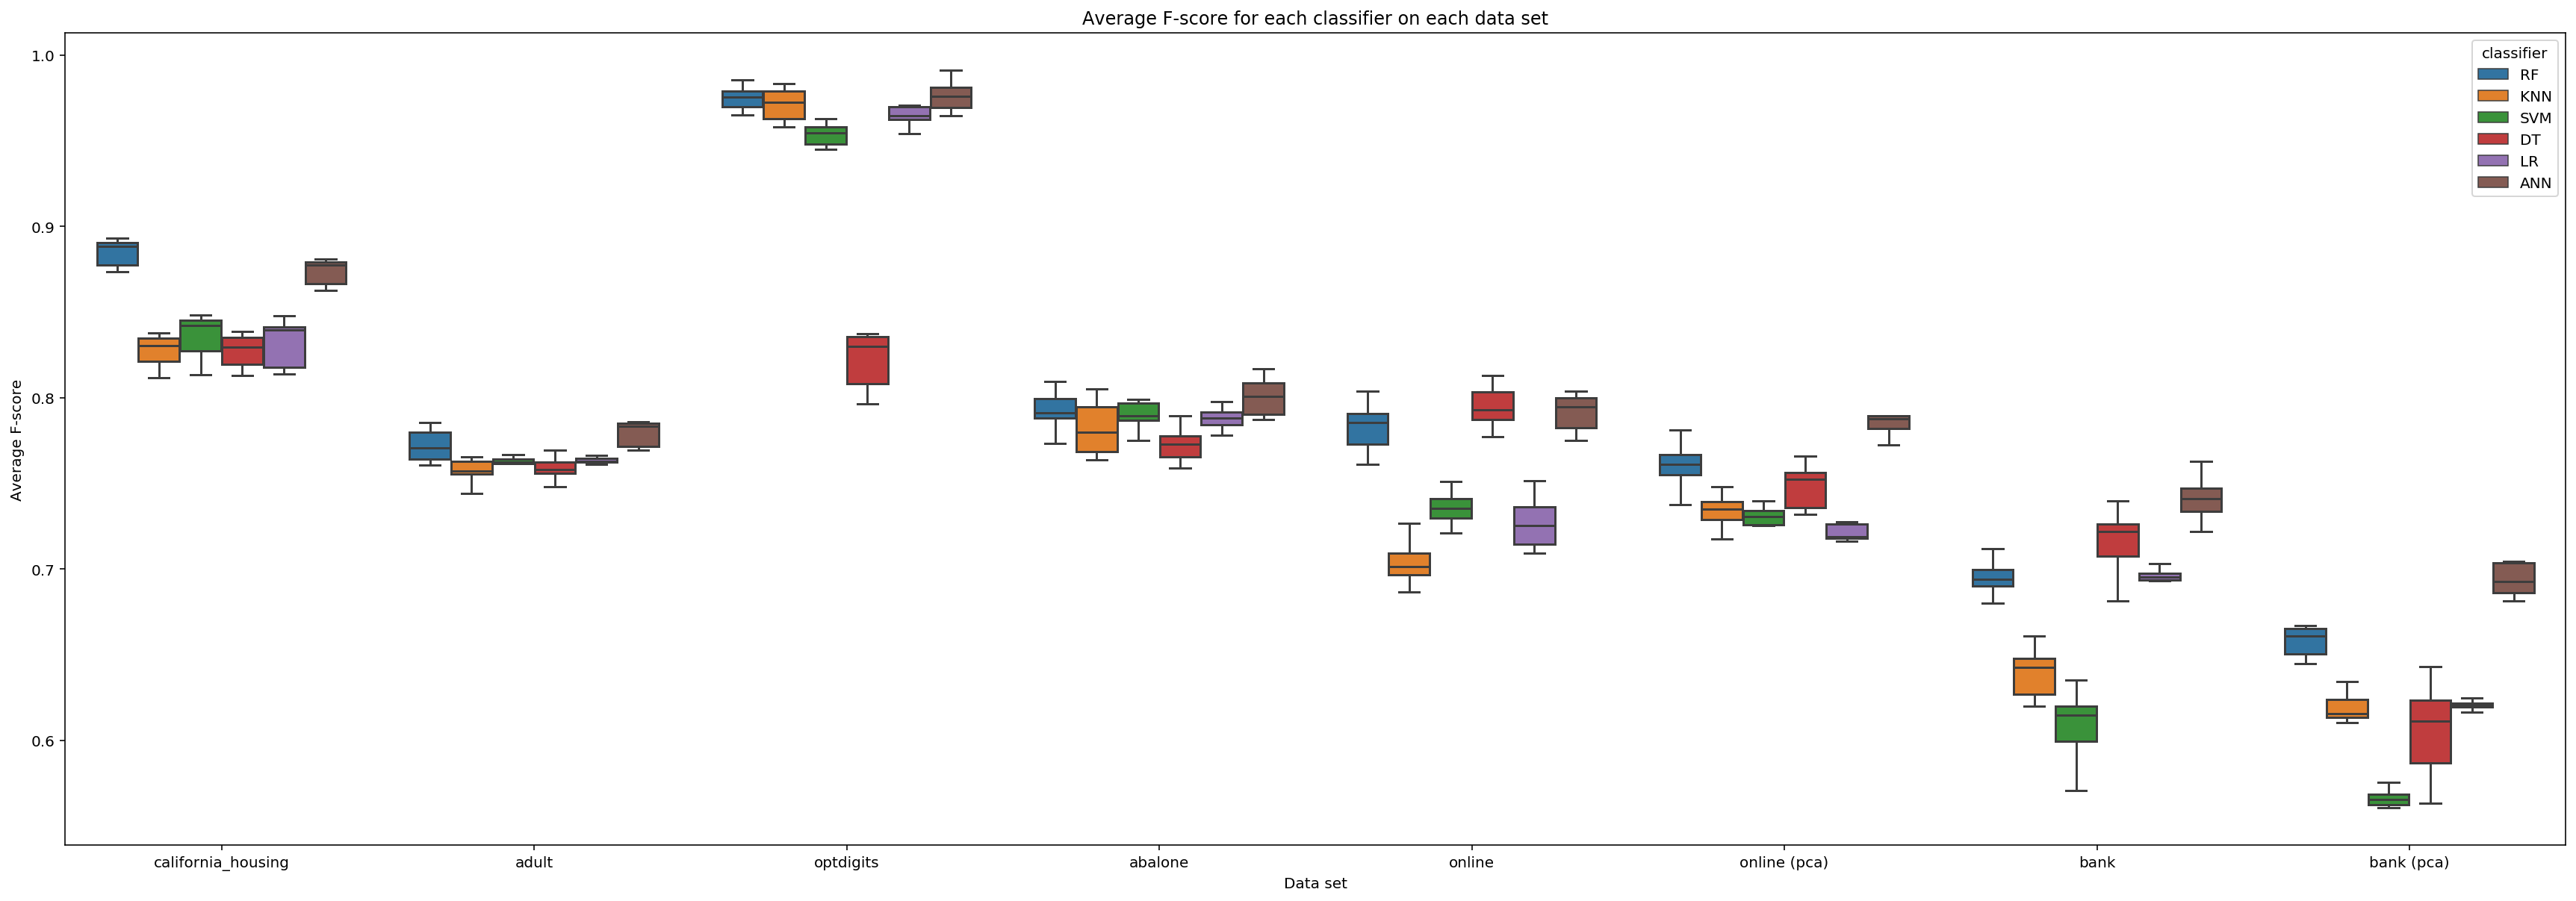

In [12]:
figure = plt.figure(figsize=(30, 10))
ax = sns.boxplot(x = 'dataset', y='f_score', hue='classifier', data=df, showfliers=False)
ax.set(xlabel='Data set', ylabel='Average F-score')
ax.set_title('Average F-score for each classifier on each data set');
plt.savefig('plots/avg_f_score_per_classifier_dataset', dpi=1000)

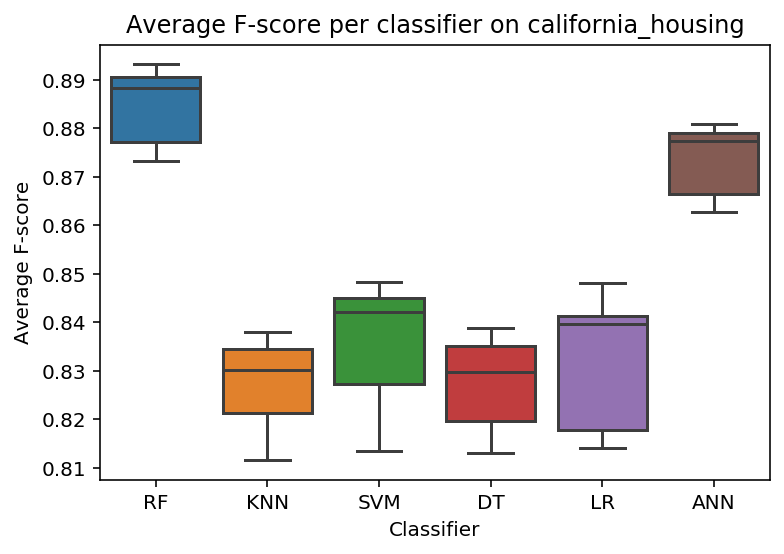

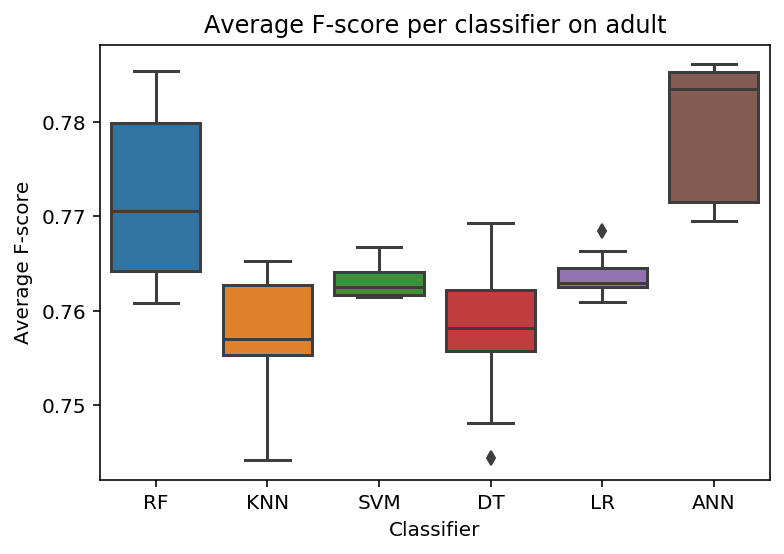

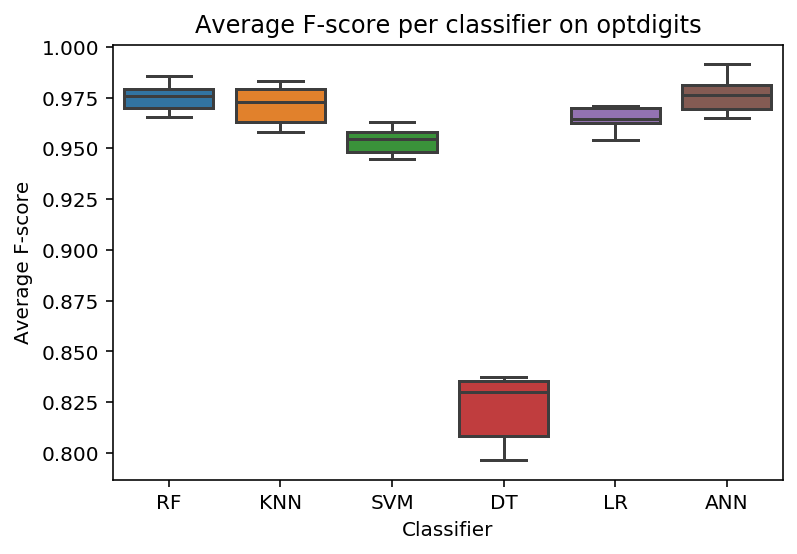

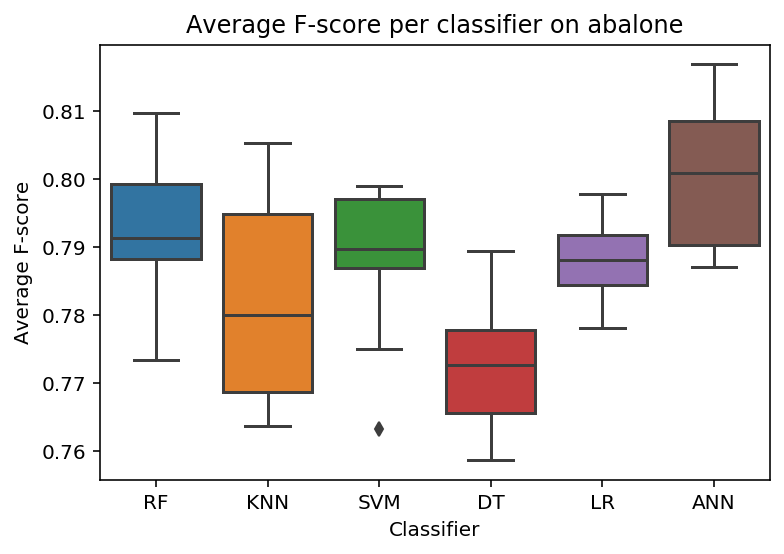

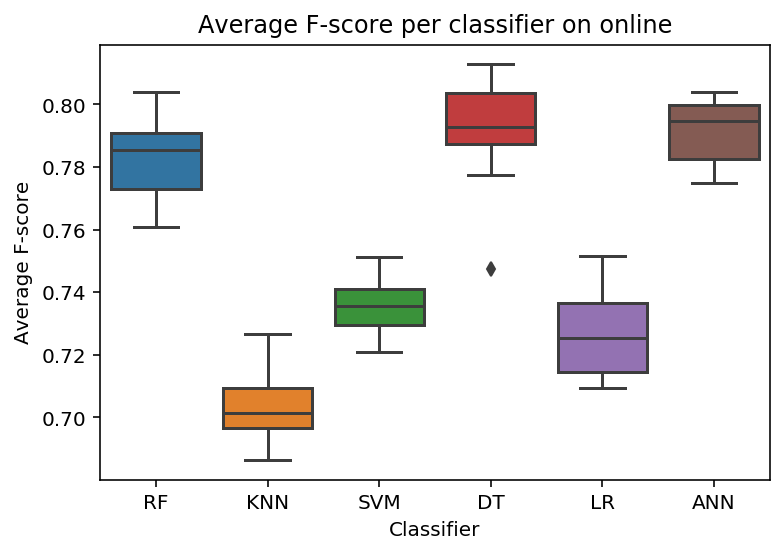

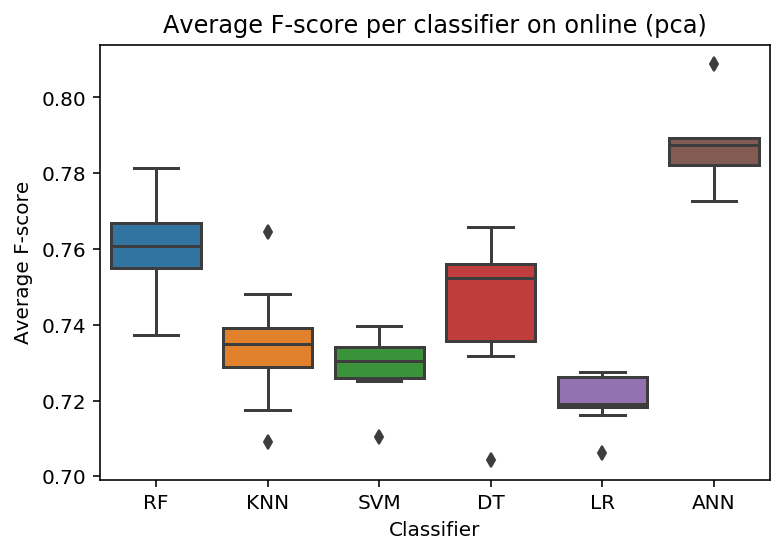

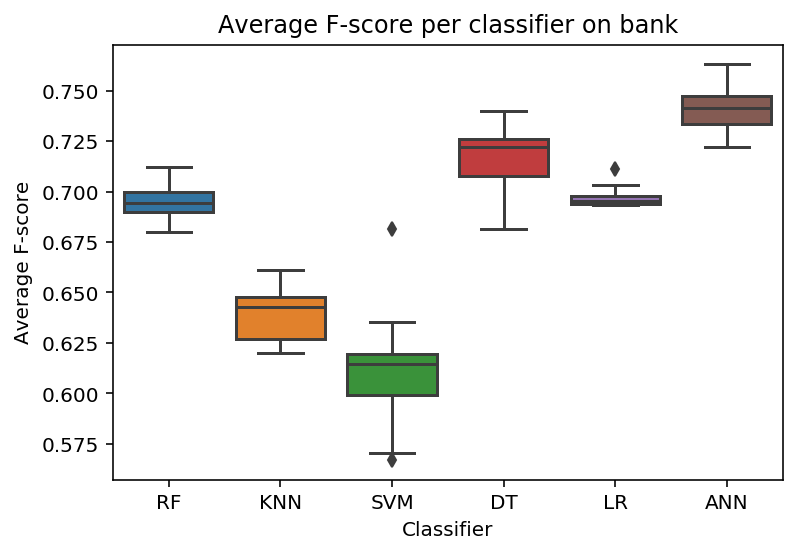

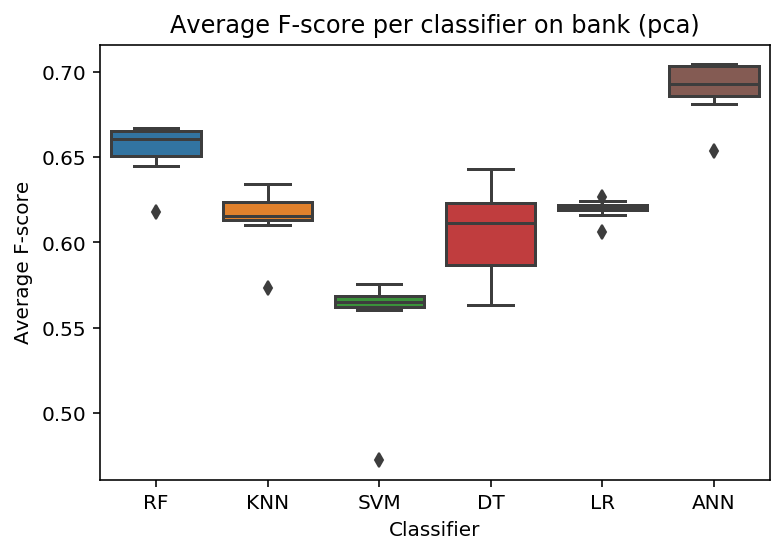

In [13]:
def boxplots_per_data_set(df = df):
    for dataset in df['dataset'].unique():
        ax = sns.boxplot(
            x='classifier',
            y='f_score',
            data=df[df['dataset'] == dataset]
        )
        ax.set(xlabel='Classifier', ylabel='Average F-score')
        ax.set_title(f'Average F-score per classifier on {dataset}');
        plt.savefig(f'plots/avg_f_score_per_classifier_{dataset}', dpi=1000)
        plt.show()

boxplots_per_data_set()

In [14]:
def cross_validation_scores(df):
    df = df.copy()
    df['cv'] = df['cv_results'].map(lambda d: list(zip(d['mean_test_score'], d['params'])))
    df = df.explode('cv')
    df['cv_test_score'] = df['cv'].map(lambda t: t[0])
    df['cv_params'] = df['cv'].map(lambda t: tuple(sorted((t[1].items()))))

    return df.drop(columns = [
            'f_score', 'training_accuracy', 'validation_accuracy', 'test_accuracy', 'params', 'cv_results', 'cv'
        ]
    ).reset_index()

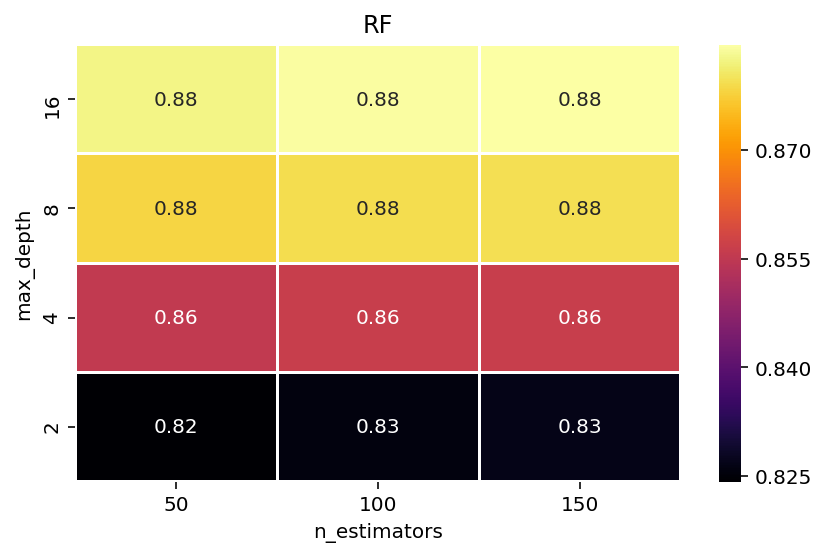

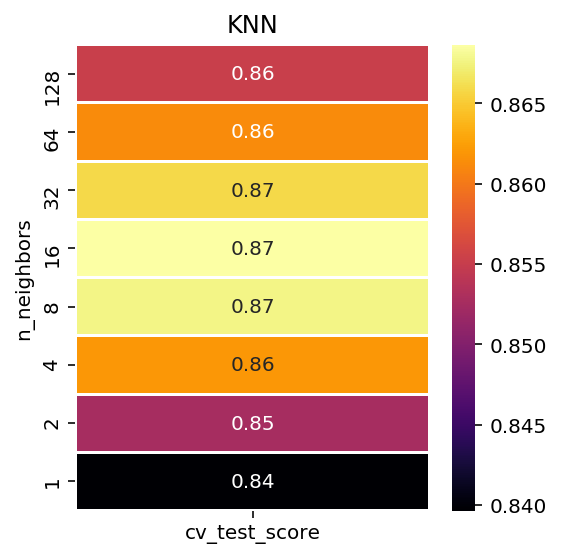

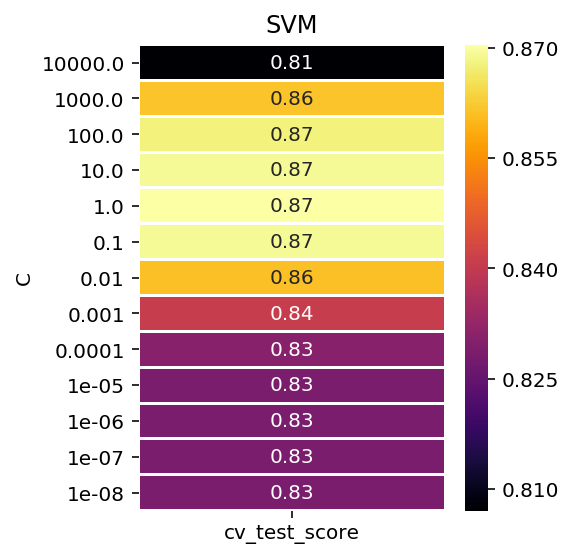

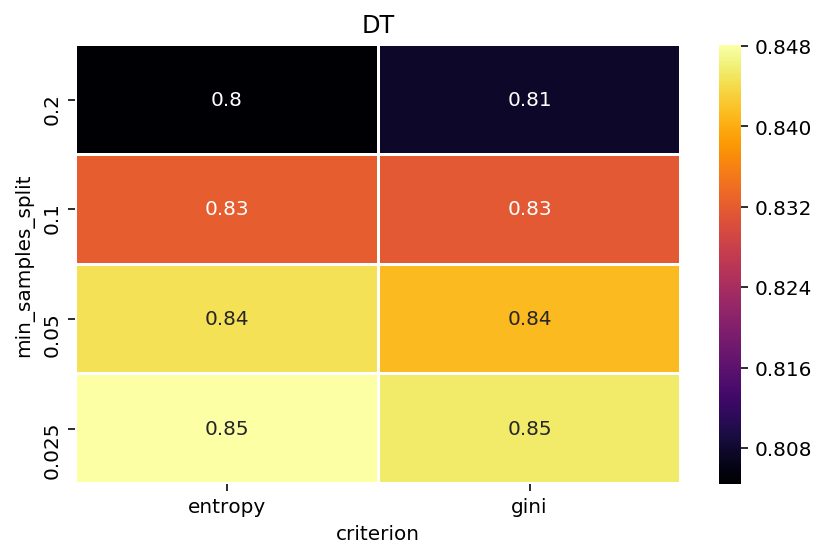

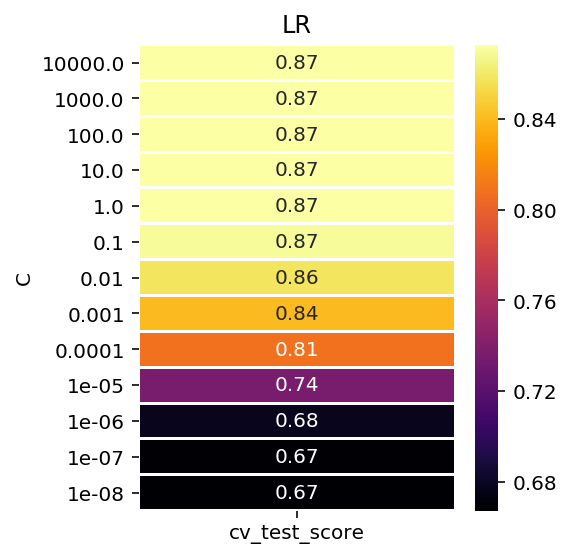

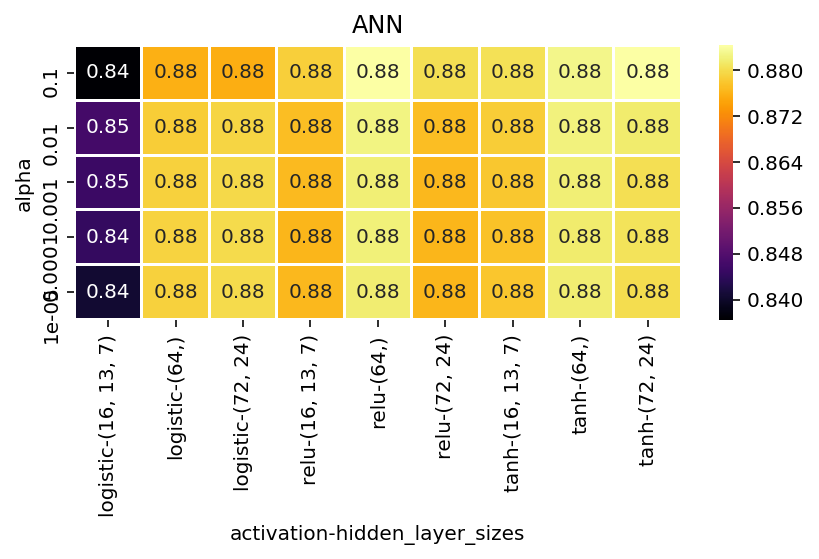

In [19]:

cvdf = cross_validation_scores(df)
for clf in cvdf['classifier'].unique():
    df2 = cvdf[cvdf['classifier'] == clf]
    # How many dimenions we're doing cross-validation across
    #cv_dimensions = df2['cv_params'].map(len).min()
    dimensions = [name for name, _ in df2['cv_params'].iloc[0]]
    
    for i, dim in enumerate(dimensions):
        df2[dim] = df2['cv_params'].map(lambda t: t[i][1])
        
    if len(dimensions) == 1:
        plt.figure(figsize=(4, 4))
    
    df2 = df2.drop(columns = ['cv_params'])
    index = [max(dimensions, key = lambda d: len(df2[d].unique()))]
    columns = [x for x in dimensions if x not in index]
    #print(f'index = {index}, columns = {columns}, #s = {[(type(len(df2[dim].unique())), len(df2[dim].unique())) for dim in dimensions]}, #max = {df2[]}')
    #index = dimensions[:1] 
    #columns = dimensions[1:]
    
    pivot = pd.pivot_table(df2, values='cv_test_score', index=index, columns=columns, aggfunc=np.average)
    ax = sns.heatmap(pivot, cmap='inferno', linewidths=1, annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.invert_yaxis()
    ax.set_title(f'{clf}')
    
    plt.tight_layout()
    plt.savefig(f'plots/cv_results_{clf}', dpi=1000)
    plt.show()

In [16]:
def explode_hyperparameters(df, clf):
    df = cross_validation_scores(df)
    df = df[df['classifier'] == clf]
    
    dimensions = [name for name, _ in df['cv_params'].iloc[0]]
    
    for i, dim in enumerate(dimensions):
        df[dim] = df['cv_params'].map(lambda t: t[i][1])
        
    return df.drop(columns = ['cv_params']).reset_index()

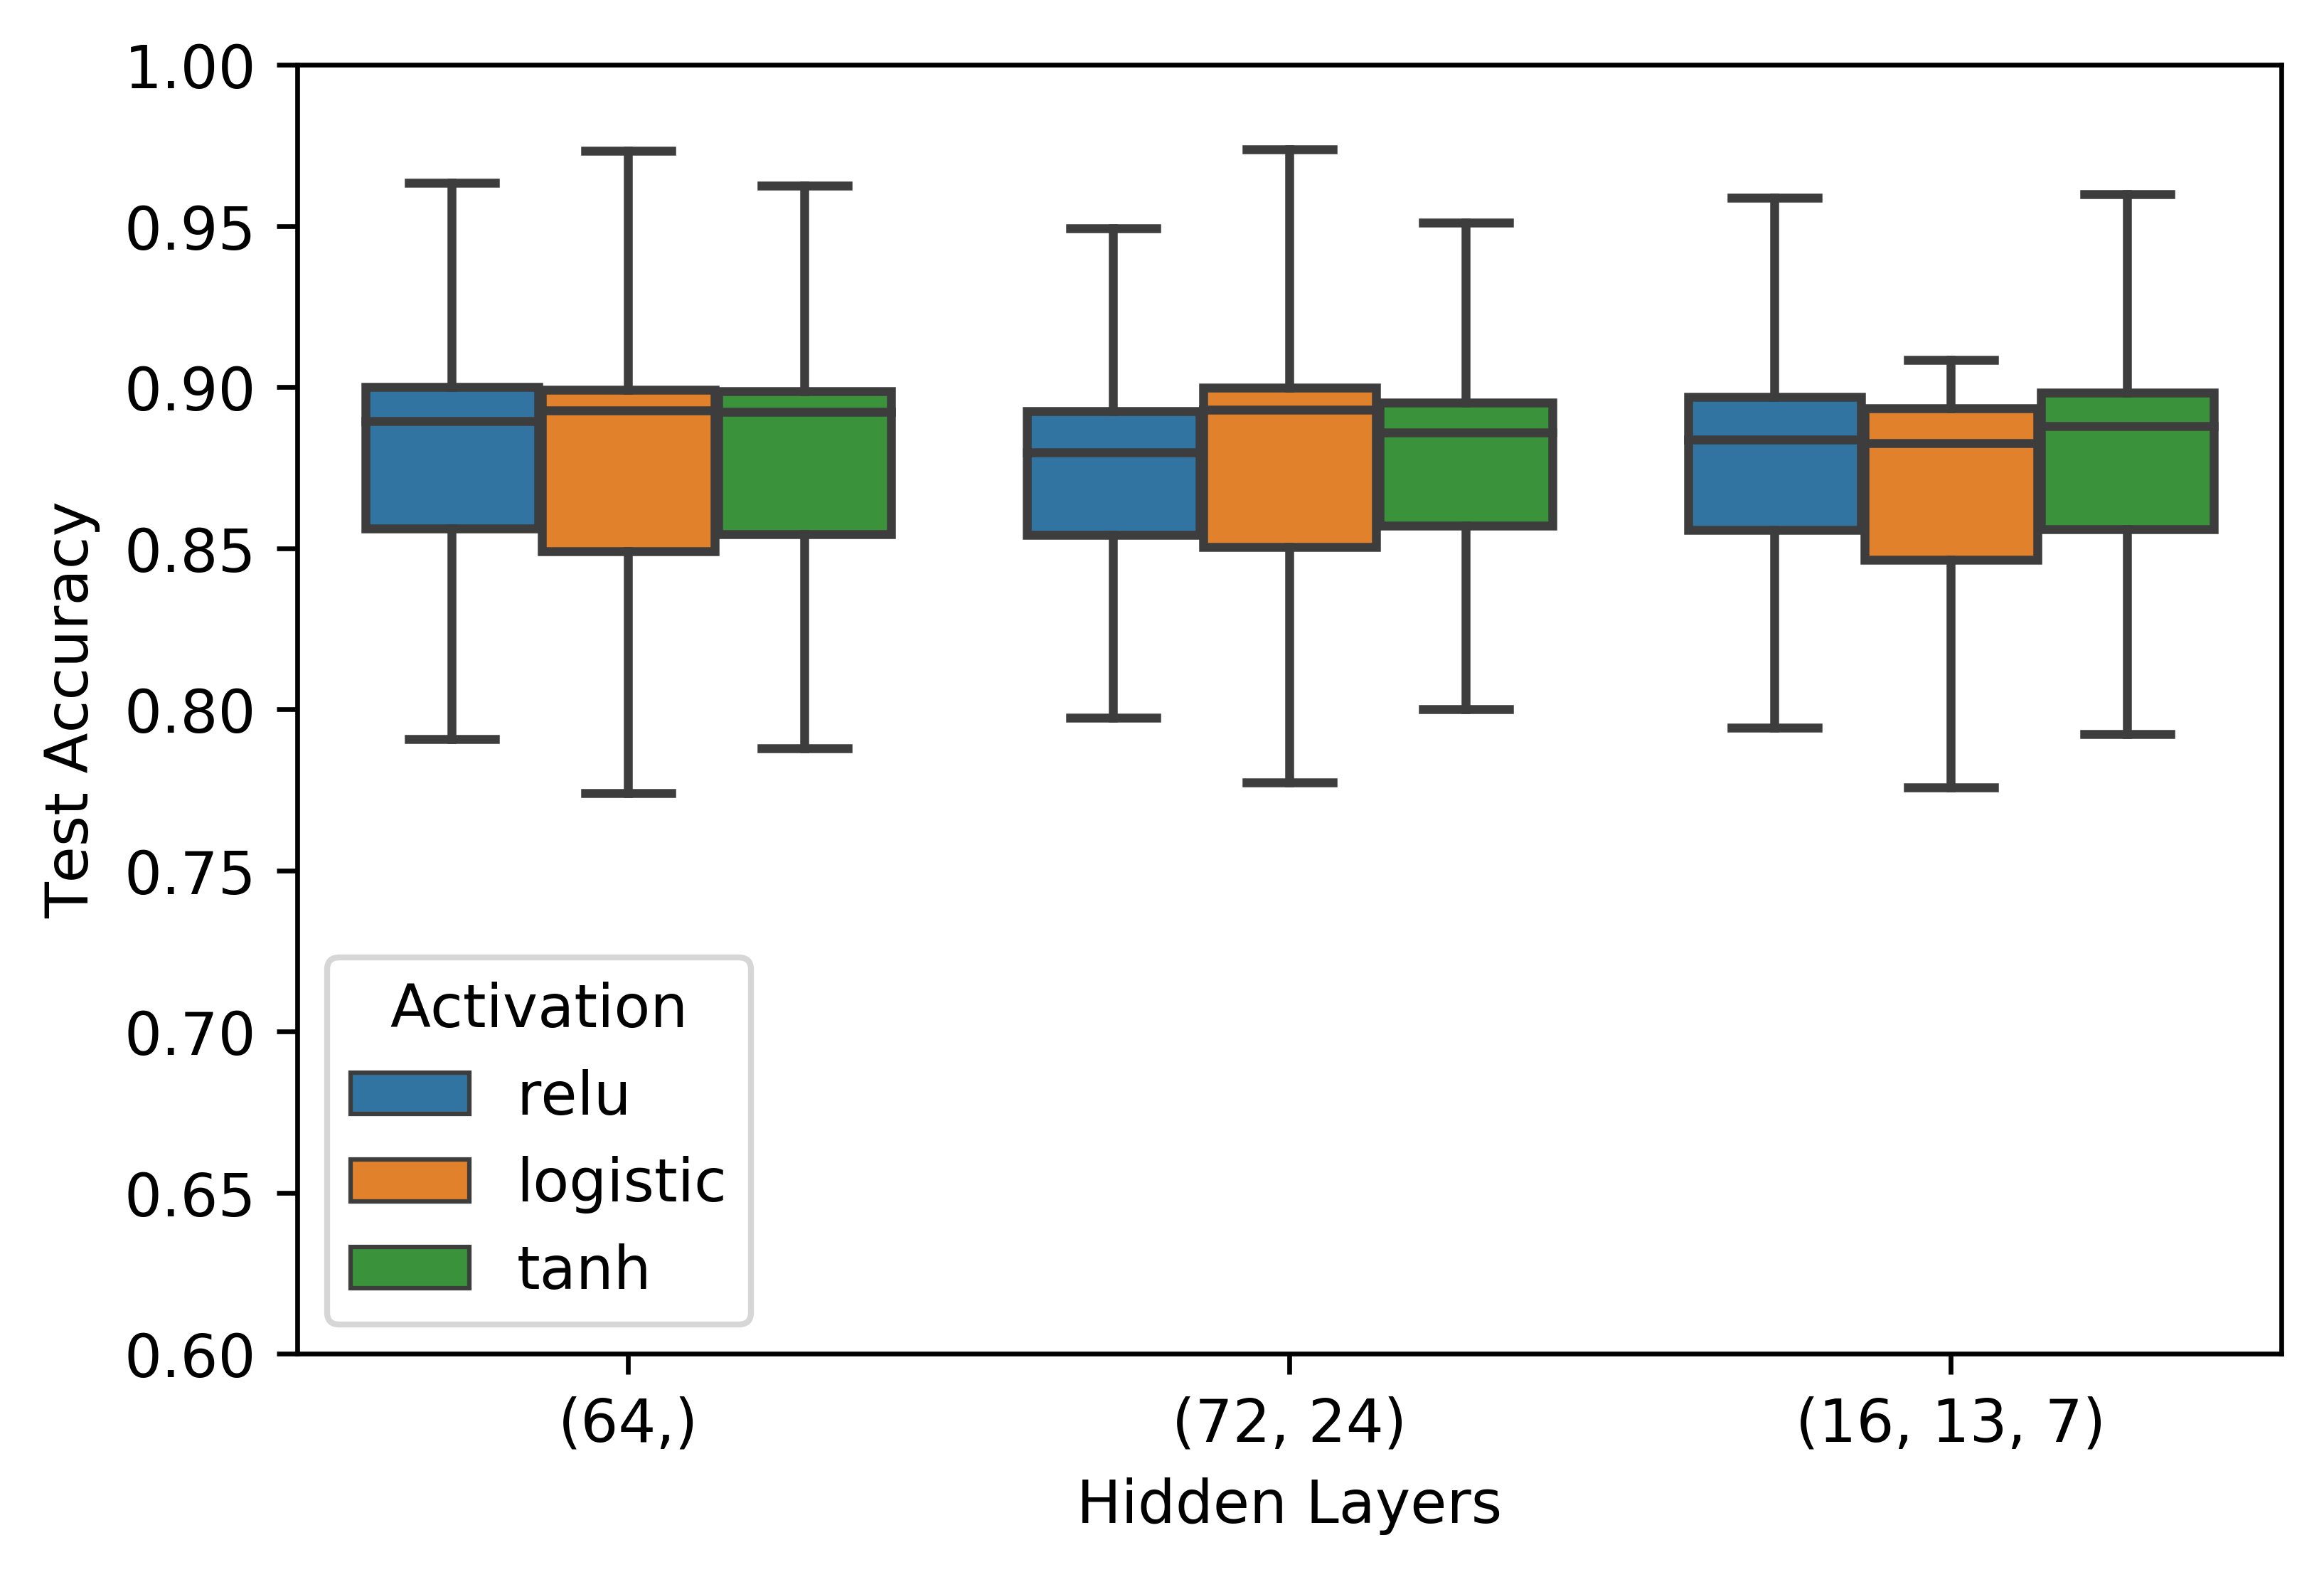

In [17]:
# Logistic regression on (16, 13, 7) has some pretty huge outliers. Including them severely distorts the
# chart, so we'll not show them (showfliers=False).
plt.figure(dpi=300)
data = explode_hyperparameters(df, 'ANN')
ax = sns.boxplot(x = 'hidden_layer_sizes', y='cv_test_score', hue='activation', data=data, showfliers=False)
ax.set(xlabel='Hidden Layers', ylabel='Test Accuracy', ylim=(0.60, 1.00))
ax.legend().set_title('Activation');
plt.savefig(f'plots/ann_cv_avg_test_score_per_hyperparameters', dpi=1000)